In [1]:
from map_tool_box.modules import Data_Structure
from map_tool_box.modules import Data_Map
from map_tool_box.modules import Action
from map_tool_box.modules import Astar
from map_tool_box.modules import Utils
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from pathlib import Path
import numpy as np
import random
import os

# set params and read map from file for collision detection

In [2]:
map_name = 'AirSimNH'
astar_version = 'temp'

DATA_DIR = Utils.get_global('data_directory')
ASTAR_DIR = Path(DATA_DIR, 'maps', map_name, 'paths', astar_version)
                
data_map = Data_Map.DataMapRoof(map_name)

In [ ]:

# OUT_DIR = Path(DATA_DIR, 'maps', map_name, 'paths', 'temp')

# for i in range(100):
#     fpath = Path(ASTAR_DIR, f'path_list__{i}.p')
#     out_path = Path(OUT_DIR, f'path_list__{i}.p')
#     if not os.path.exists(fpath):
#         continue
#     path_list = Utils.pickle_read(fpath)
#     new_path_list = []
#     for idx, path_info in enumerate(path_list):
#         iterations = path_info[0]      
#         path = path_info[1]
#         new_path = []
#         for act_pose in path:
#             x, y, z, direction, action = act_pose
#             point = Data_Structure.Point(x, y, z, direction, action)
#             new_path.append(point)
#         new_path_list.append([iterations, new_path])
#     Utils.pickle_write(out_path, new_path_list)

# read paths

In [3]:
path_lists = {}
max_iterations = 0
n_paths = 0
for i in range(100):
    fpath = Path(ASTAR_DIR, f'path_list__{i}.p')
    if not os.path.exists(fpath):
        continue
    path_list = Utils.pickle_read(fpath)
    for idx, path_info in enumerate(path_list):
        iterations = path_info[0]
        max_iterations = max(max_iterations, iterations)        
        path = path_info[1]
        path_list[idx] = path
    path_lists[i] = path_list
    print(i, len(path_list))
    n_paths += len(path_list)
print('n_paths', n_paths)
print('max_iterations', max_iterations)

0 1000
1 1000
2 1000
3 1000
4 1000
5 1000
6 1000
7 1000
8 1000
9 1000
10 1000
11 1000
12 1000
13 1000
14 1000
15 1000
16 1000
17 1000
18 1000
19 1000
20 1000
21 1000
22 1000
23 1000
24 1000
25 1000
26 1000
27 1000
28 1000
29 1000
30 1000
31 1000
32 1000
33 1000
34 1000
35 1000
36 1000
37 1000
38 1000
39 1000
40 1000
41 1000
42 1000
43 1000
44 1000
45 1000
46 1000
47 1000
48 1000
49 1000
50 1000
51 1000
52 1000
53 1000
54 1000
55 1000
56 1000
57 1000
58 1000
59 1000
60 1000
61 1000
62 1000
63 1000
64 1000
65 1000
66 1000
67 1000
68 1000
69 1000
70 1000
71 1000
72 1000
73 1000
74 1000
75 1000
76 1000
77 1000
78 1000
79 1000
80 1000
81 1000
82 1000
83 1000
84 1000
85 1000
86 1000
87 1000
88 1000
89 1000
90 1000
91 1000
92 1000
93 1000
94 1000
95 1000
96 1000
97 1000
98 1000
99 1000
n_paths 100000
max_iterations 44271


# bin by the number of actions for each path (curric difficulty)

{1: 41, 2: 217, 3: 736, 4: 1705, 5: 2604, 6: 3534, 7: 4096, 8: 4736, 9: 5315, 10: 5733, 11: 6040, 12: 6427, 13: 6330, 14: 6390, 15: 6248, 16: 6119, 17: 5803, 18: 5428, 19: 4983, 20: 4210, 21: 3475, 22: 2898, 23: 2158, 24: 1634, 25: 1140, 26: 789, 27: 508, 28: 325, 29: 201, 30: 113, 31: 49, 32: 14, 33: 1}


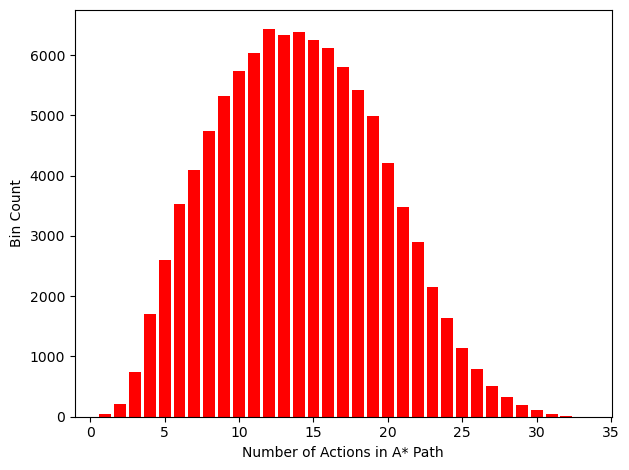

In [4]:
actions_counter = {}
for seed in path_lists:
    path_list = path_lists[seed]
    for path in path_list:
        n_actions = len(path)-1
        if n_actions not in actions_counter:
            actions_counter[n_actions] = 0
        actions_counter[n_actions] += 1
actions_counter = {key: value for key, value in sorted(actions_counter.items())}
print(actions_counter)

fig, ax = plt.subplots()

ax.bar([int(level) for level in actions_counter], [actions_counter[level] for level in actions_counter], color='red')
ax.set_ylabel('Bin Count')
ax.set_xlabel('Number of Actions in A* Path')
fig.tight_layout()
plt.show()

# heat map of visited points

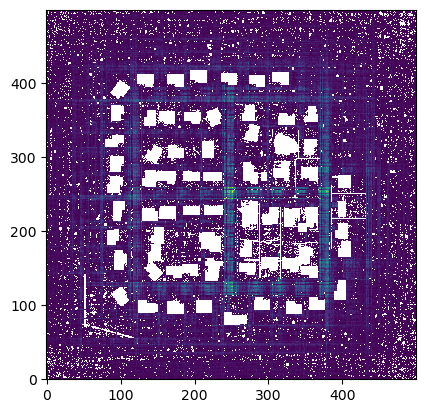

In [5]:
map_arr = np.zeros(data_map.roofs_array.shape)
for seed in path_lists:
    path_list = path_lists[seed]
    for path in path_list:
        for point in path:
            x, y = point.x, point.y
            xi = x + data_map.x_shift
            yi = y + data_map.y_shift
            map_arr[xi, yi] += 1
map_arr[map_arr == 0] = np.nan
cmap = plt.colormaps['viridis']
cmap.set_bad('white')
cbar = plt.imshow(map_arr.T, origin='lower', interpolation='nearest', cmap=cmap)
plt.show()

#Utils.pickle_write('astar_map_arr.p', map_arr)

# test paths with a control algorithm 

In [8]:
def test_path(path, view=False):
    start = path[0]
    result = 'success'
    last_point = start
    if view:
        fig, ax = plt.subplots()
        data_map.plot_map(fig, ax)
    for point in path[1:]:
        if view:
            data_map.plot_agent(fig, ax, point, show_fov=False)
        next_point, valid = point.action.act(data_map, last_point)
        if not valid:
            result = 'invalid'
            break
        if next_point.x != point.x or next_point.y != point.y or next_point.z != point.z or point.direction != next_point.direction:
            result = 'missmatch'
            break
        last_point = point
    return result

In [9]:
results = {}
for seed in path_lists:
    results[seed] = {}
    path_list = path_lists[seed]
    for idx, path in enumerate(path_list):
        result = test_path(path, view=False)
        if 'success' not in result:
            print(seed, idx, result)
            result = test_path(path, view=True)
        results[seed][idx] = result

# partition by number of actions and split to train/val/test

In [10]:
# train/val regions
buffer = 0

xmin = -240 + buffer
xmax = 240 - buffer
ymin = -240 + buffer
ymax = 240 - buffer

val_xmin = xmin + buffer
val_xmax = 0 - buffer
val_ymin = 0 + buffer
val_ymax = ymax - buffer

train_paths = {n_actions:[] for n_actions in actions_counter}
val_paths = {n_actions:[] for n_actions in actions_counter}
test_paths = {n_actions:[] for n_actions in actions_counter}

for seed in path_lists:
    path_list = path_lists[seed]
    for path in path_list:
        n_actions = len(path)-1
        in_train_region = True
        in_val_region = True
        out_of_bounds = False
        
        for point in path:
            x, y = point.x, point.y
            out_of_bounds = x >= xmax or x < xmin or y >= ymax or y < ymin
            if out_of_bounds:
                break
            in_train_region = in_train_region and (x >= val_xmax or x < val_xmin or y >= val_ymax or y < val_ymin)
            in_val_region = in_val_region and (x < val_xmax and x >= val_xmin and y < val_ymax and y >= val_ymin)
            
        if out_of_bounds:
            continue
            
        if in_train_region:
            train_paths[n_actions].append(path)
        elif in_val_region:
            val_paths[n_actions].append(path)
        else:
            test_paths[n_actions].append(path)

for n_actions in actions_counter:
    print(n_actions, len(train_paths[n_actions]), len(val_paths[n_actions]), len(test_paths[n_actions]) )

1 26 11 0
2 144 53 5
3 473 147 28
4 1019 360 98
5 1549 472 218
6 1966 637 429
7 2275 626 607
8 2567 650 870
9 2658 631 1270
10 2837 518 1610
11 2863 366 2014
12 2846 256 2431
13 2586 169 2693
14 2450 89 2839
15 2258 24 2997
16 2121 10 2962
17 1880 2 2896
18 1697 0 2681
19 1417 0 2492
20 1072 0 2085
21 767 0 1783
22 577 0 1443
23 389 0 1115
24 243 0 863
25 163 0 560
26 101 0 395
27 76 0 213
28 25 0 142
29 14 0 70
30 5 0 30
31 7 0 6
32 1 0 1
33 0 0 0


# bin the curriculum learning levels

In [14]:
low = 4
high = 14


train_curric = {}
val_curric = {}
test_curric = {}

for n_actions in actions_counter:
    if n_actions <= low:
        level = 'low'
    elif n_actions >= high:
        level = 'high'
    else:
        level = str(n_actions)
    if level not in train_curric:
        train_curric[level] = []
        val_curric[level] = []
        test_curric[level] = []

    train_curric[level].extend(train_paths[n_actions])
    val_curric[level].extend(val_paths[n_actions])
    test_curric[level].extend(test_paths[n_actions])

for level in train_curric:
    train_curric[level] = train_curric[level]
    val_curric[level] = val_curric[level]
    test_curric[level] = test_curric[level]
    
# print states (and shuffle order)
for level in train_curric:
    print(level, len(train_curric[level]), len(val_curric[level]), len(test_curric[level]))
    random.shuffle(train_curric[level])
    random.shuffle(val_curric[level])
    random.shuffle(test_curric[level])

Utils.pickle_write(Path(ASTAR_DIR, 'curriculum', 'train_dict.p'), train_curric)
Utils.pickle_write(Path(ASTAR_DIR, 'curriculum', 'val_dict.p'), val_curric)
Utils.pickle_write(Path(ASTAR_DIR, 'curriculum', 'test_dict.p'), test_curric)

low 1662 571 131
5 1549 472 218
6 1966 637 429
7 2275 626 607
8 2567 650 870
9 2658 631 1270
10 2837 518 1610
11 2863 366 2014
12 2846 256 2431
13 2586 169 2693
high 15263 125 25573
